# Automatic parallel scripts for computing timeseries densities of CoMP or uCoMP data

### Input data are >= Level-1 reduced matching pairs of Fe XIII 1074.6nm and 1079.8nm observations 

The **COMP_DENS** function needs a chianti look-up table file which is included in this repository. 

The data and metadata are read directly from downloaded .fts files. Examples use the Level-2 polarization data.

Input data can be from either CoMP or uCoMP. The processing take only one frame at a time, but the timeseries setup below will enable use of temporal sequence data.

The **work_1pix** worker function is required for the parallel implementation.

These scripts are provided "as-is", are not free of bugs, and nor safe from improper usage. Please mind inherent assumptions.

More information on the method and software codes can be found in [Paraschiv & Judge, 2022](https://ui.adsabs.harvard.edu/abs/2022SoPh..297...63P/abstract) and [Schad & Dima, 2020](https://ui.adsabs.harvard.edu/abs/2020SoPh..295...98S/abstract).

Contact: Alin Paraschiv, NSO ---- arparaschiv at nso edu


In [156]:
import numpy as np                       ## in COMP_DENS
import multiprocessing                   ## in COMP_DENS
from tqdm import tqdm                    ## in COMP_DENS
from datetime import datetime,timedelta  ## in COMP_DENS
#from scipy.io import readsav             ## in COMP_DENS; only if using the deprecated sswidl table
from scipy import interpolate            ## in work_1pix 

def COMP_DENS(i1074,i1079,chianti_link,header_1074,header_1079,integrated=False):
## compute the density from two stokes I observations (serialized parallel runs for 1 pixel at a time) of Fe XIII assuming:
##    - a line ratio look-up table created using chianti atomic data.
##    - accurate header pointing information
##    - that the data arrays are aligned properly
##    - others ??
    
## - Two chianti look-up tables are computed via PyCELP or SSWIDL(deprecated) and imported via the "chianti_link" path given to this function.
## - Requires full observation headers (1 header per map) from both Fe XIII line datasets.
## - Requires the numpy, multiprocessing, tqdm, scipy's interpolate and io.readsav imports for loading the older IDL look-up table.
    
## Ingesting the inputs and shaping the return array. Sanity checks will return 0 in case something is incompatible.
    if np.ndim(i1074) == 2: ## Function understands a set of two 2D maps containing Stokes I measurements.
        density=np.zeros(i1074.shape,dtype=np.float32)   
        if (i1074.shape != i1079.shape):           ## sanity check 
            print("Input arrays are not of the same physical shape. Aborting!")
            return density                         ## a zero array at this point
        print('Intensity only maps ingested. Continuing!')
    elif np.ndim(i1074) == 3: ## Function understands a set of two 2D maps containing Stokes I measurements.
        density=np.zeros(i1074.shape[:2],dtype=np.float32)   
        if (i1074.shape != i1079.shape):           ## sanity check 
            print("Input arrays are not of the same physical shape. Aborting!")
            return density                        ## a zero array at this point
        print('Intensity, doppler, and linewidth maps ingested. Continuing!')

    ## Input not compatible with this function
    else:
        print("Input arrays dimensions not understood. Aborting!")
        return np.zeros((2,2))

## theoretical chianti ratio calculations created via PyCELP or SSWIDL        
    ## read the chianti table         
    if (chianti_link[-4:]    == ".npz"):                     ## default
        chianti_table        =  dict(np.load(chianti_link))  ## variables (h,den,rat) directly readable by work_1pix .files required for loading the data directly.
    elif (chianti_link[-4:]  == ".sav"):                     ## deprecated
        print("The sswidl look-up table is deprecated. The pycelp look-up table is better supported and recommended at this stage")
        chianti_table        =  readsav(chianti_link)        ## variables  (h,den,rat) directly readable by work_1pix
        chianti_table["den"] =  chianti_table["den"][0,:]    ## density sample values are the same at all heights. Use just one instance.
    else:
        print("Chianti look-up table not found. Is the path correct?")
        return density                                ## a zero array at this point  
    #print(chianti_table.keys())                      ## Debug - check the arrays
    
    ##  in the save files:
    ## 'h' is an array of heights in solar radii ranged 1.01 - 2.00(pycelp) or 1.01 - 1.50(sswidl);  
    ## 'den' is an array of density (ranged 6.00 to 12.00 (pycelp) or 5.0 to 13.0 (sswidl); the broader interval is not really recommended here. 
    ## 'rat' is a 2D array containing line ratios corresponding to the density range values at each distinct height.
    
    ##  To query the look-up table:
    ##  print(chia['h'],chia['h'].shape,chia['rat'].shape,chia['den'].shape)

    ## look-up table resolutions
    ## pycelp: h is of shape [99]; den and rat are arrays of shape [99, 120] corresponding to the 99 h height values and 120 density values
    ## sswidl: h is of shape [50]; den and rat are arrays of shape [50,  33] corresponding to the 50 h height values and  33 density values

## Print the difference in time between the two frames if you want
    FMT =  '%Y-%m-%dT%H:%M:%S.%f'                 ## format for the dates that are read
    ## Compute the seconds difference between each frame from the shorter dataseries and the entire longer dataseries, 
    if header_1074['instrume']   =="UCoMP": 
        aa0 = datetime.strptime(header_1074['DATE-OBS'], FMT) #datetime.strptime(header_1074['DATE-OBS']+'T'+header_1074['TIME-OBS']+'.00', FMT) 
        bb0 = datetime.strptime(header_1079['DATE-OBS'], FMT) #datetime.strptime(header_1079['DATE-OBS']+'T'+header_1079['TIME-OBS']+'.00', FMT)
        print("Time between selected frames: " + str((np.abs( aa0 - bb0 )).total_seconds()) + ' [s]' ) 
    elif header_1074['instrume'] =="COMP":        ## This includes leap sedonds that are not compatible with datetime module. Solve "60"s by changing to "59"s    
        aa0 = header_1074['DATE-OBS']+'T'+header_1074['TIME-OBS']+'.00'
        bb0 = header_1079['DATE-OBS']+'T'+header_1079['TIME-OBS']+'.00'
        if aa0[-5:-3] == "60":   aa0 = header_1074['DATE-OBS']+'T'+header_1074['TIME-OBS'][:-2]+'59.00'
        if bb0[-5:-3] == "60":   bb0 = header_1079['DATE-OBS']+'T'+header_1079['TIME-OBS'][:-2]+'59.00'
        aa0 = datetime.strptime(aa0, FMT) 
        bb0 = datetime.strptime(bb0, FMT)
        print("Time between selected frames: " + str((np.abs( aa0 - bb0 )).total_seconds()) + ' [s]' )        
  
## set up the cpu worker and argument arrays
    p         = multiprocessing.Pool(processes=multiprocessing.cpu_count()-2,maxtasksperchild = 10000)     ## dynamically defined from system query as total CPU core number - 2
    ## argument index keeper for splitting tasks to cpu cores
    ## two branches to separate slingle slits vs rasters
    arg_array = []
                                                                                              ## Raster slit branch
    for xx in range(i1074.shape[0]): 
        for yy in range(i1074.shape[1]): 
            arg_array.append((xx,yy,i1074[xx,yy],i1079[xx,yy],header_1074,header_1079,chianti_table,integrated)) ## Only one header instance goes in for oa set of maps. pointing should be the same in both.

    rs        = p.starmap(work_1pix,arg_array)
    p.close()
    pbar      = tqdm(total=len(arg_array))  ## progress bar implmentation via tqdm
    for i,res in enumerate(rs):
        xx,yy,density[xx,yy] = res 
        pbar.update()
    pbar.close()

    return density


def work_1pix(xx,yy,a_obs,b_obs,a_hdr,b_hdr,chianti_table,integrated):
    ## compute the ratio of the observation ## 1074/1079 fraction, same as rat component of the chianti_table 
    
    ## Sanity checks at pixel level
    if integrated and b_obs[0] == 0:                    ## don't divide by 0
        return xx,yy,0                                  ## return 0 value        
    elif  integrated == False and b_obs == 0:           ## don't divide by 0
        return xx,yy,0                                  ## return 0 value

    ## line ratio calculations for peak and integrated quantities
    ## line ratio calculations of integrated line counts, requires amplitude, distribution center and sigma parameters.
    ## There are two ways of doing this; setting a wavelength linearspace and then sum the gaussian over that inverval, OR take the analytical gaussian integral (seems faster).
    ## to not have to load header extensions, we hardcode the central wavelngth sampling to 1074.7 and 1079.8 respectively.
    ## Distribution center and sigma need to be changed from km/s units to nm units.
    if integrated: 
        # rg_a = np.linspace(1074.1,1075.3,50) 
        # rg_b = np.linspace(1079.2,1080.4,50)
        # rat_obs  = np.sum(a_obs[0]*np.exp(-(rg_a-(1074.7+a_obs[1]*1074.7/3e5))**2/(2*(a_obs[2]*1074.7/3e5/2.355)**2)))/np.sum(b_obs[0]*np.exp(-(rg_b-(1079.8+b_obs[2]*1079.8/3e5))**2/(2*(b_obs[2]*1079.8/3e5/2.355)**2))) ##ratios of 3 point gausian integral of input fitting parameters.
        rat_obs = (a_obs[0]*np.sqrt(2*np.pi*(a_obs[2]*1074.7/3e5/2.355)**2)) / (b_obs[0]*np.sqrt(2*np.pi*(b_obs[2]*1079.8/3e5/2.355)**2))  ## Analythical gaussian integral formula.

    ## line ratio calculations for peak quantities only
    else:  
        rat_obs       = a_obs/b_obs        ## requires only one input number for each line 
        #rat_obs_noise = rat_obs*np.sqrt((np.sqrt(a_obs)/a_obs)**2+(np.sqrt(b_obs)/b_obs)**2)    ## error propagation
    
    ## another sanity check for numerical issues
    if (np.isnan(rat_obs) or np.isinf(rat_obs)):        ## discard nans and infs ratios
        return xx,yy,0                                  ## return 0 value
    
    else:                                               ## main loop for valid "rat_obs" value
        ## find the corresponding height (in solar radii) for each pixel
        if a_hdr['instrume']   == "UCoMP":
            rpos = np.sqrt( (a_hdr['CRVAL1'] + a_hdr['CDELT1']*(xx-a_hdr['CRPIX1']))**2 + (a_hdr['CRVAL2'] + a_hdr['CDELT2']*(yy-a_hdr['CRPIX2']))**2 ) / a_hdr['RSUN_OBS']
        elif a_hdr['instrume'] == "COMP":                
            rpos = np.sqrt( (a_hdr['CRVAL1'] + a_hdr['CDELT1']*(xx-a_hdr['CRPIX1']))**2 + (a_hdr['CRVAL2'] + a_hdr['CDELT2']*(yy-a_hdr['CRPIX2']))**2 ) / a_hdr['RSUN']        
        else:                                           ## here you can modify add other image-like datasources
            return xx,yy,0                              ## return 0 value
        
        subh = np.argwhere(chianti_table['h'] > rpos)                                                                                  
        
        ## if height is greater than maximum h (1.5R_sun as in the currently implemented table) just use the 1.5R_sun corresponding ratios.
        if len(subh) == 0: 
            subh = [-1]       
        
        ## make the interpolation function; Quadratic as radial density drop is usually not linear
        ifunc = interpolate.interp1d(chianti_table['rat'][subh[0],:].flatten(),chianti_table['den'], kind="quadratic",fill_value="extrapolate")  
        
        ## apply the interpolation to the data 
        dens_1pix       = ifunc(rat_obs)                                                                                      
        #dens_1pix_noise = ifunc(rat_obs+rat_obs_noise) - dens_1pix
       
        ## debug prints
        #print("Radius from limb: ",rpos," at pixel positions (",xx,yy,")")         ## debug
        #print(len(subh),rpos/rsun)                                                 ## debug          
        return xx,yy,dens_1pix

## A short example of using the above scripts and plotting the results:
Required input variables are:
- Fe XIII 1074.6nm fits file
- Fe XIII 1079.8nm fits file
- path to the Chianti calculation file
- header file for 1074.6nm data.
- header file for 1079.8nm data.

### CoMP example

In [2]:
from astropy.io import fits
## Both dynamics and polarization files can be used. Stokes I has the same place in the fits structures (e.g. data[1].data)

#data_1074 = fits.open("./CoMP-20120327/20120327.204955.comp.1074.polarization.fts")
#data_1079 = fits.open("./CoMP-20120327/20120327.204715.comp.1079.polarization.fts")

#data_1074 = fits.open("./CoMP-20120327/20120327.174748.comp.1074.polarization.fts")
#data_1079 = fits.open("./CoMP-20120327/20120327.174456.comp.1079.polarization.fts")


data_1074 = fits.open("./CoMP-20120327/20120327.174401.comp.1074.dynamics.fts")
data_1079 = fits.open("./CoMP-20120327/20120327.174456.comp.1079.dynamics.fts")

### uCoMP example

In [157]:
from astropy.io import fits
## Both L1 dynamics and polarization files and L2 intensity files can be used. Stokes I has the same place in the fits structures (e.g. data[1].data)

data_1074 = fits.open("./uCoMP-20220225/20220225.182056.ucomp.1074.l2.fts")
data_1079 = fits.open("./uCoMP-20220225/20220225.182341.ucomp.1079.l2.fts")

#data_1074 = fits.open("./uCoMP-20220225/20220226.002738.ucomp.1074.l2.fts")
#data_1079 = fits.open("./uCoMP-20220225/20220226.003023.ucomp.1079.l2.fts")

### Now compute the density ratio of the two-line observations 

In [161]:
dens_rat_peak = COMP_DENS(data_1074[1].data,data_1079[1].data,'./chianti_v10.1_pycelp_fe13_h99_d120_ratio.npz',data_1074[0].header,data_1079[0].header) ## line_center [1] extension calculation

Intensity only maps ingested. Continuing!
Time between selected frames: 165.21 [s]


100%|████████████████████████████| 1310720/1310720 [00:00<00:00, 2838426.51it/s]


In [158]:
## Arrange the 3 input parameters into a numpy array to feed to dens_rat
data_gauss_1074 = np.transpose(np.array((data_1074[3].data,data_1074[4].data,data_1074[5].data)),(1,2,0) )
data_gauss_1079 = np.transpose(np.array((data_1079[3].data,data_1079[4].data,data_1079[5].data)),(1,2,0) )

dens_rat_int = COMP_DENS(data_gauss_1074,data_gauss_1079,'./chianti_v10.1_pycelp_fe13_h99_d120_ratio.npz',data_1074[0].header,data_1079[0].header,integrated=True) ## line_center [1] extension calculation

Intensity, doppler, and linewidth maps ingested. Continuing!
Time between selected frames: 165.21 [s]


100%|████████████████████████████| 1310720/1310720 [00:00<00:00, 4196545.20it/s]


#### Simple plot of the results

/tmp/ipykernel_3987/88358683.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(dens_rat_peak),vmin=6.5,vmax=8.5,extent=rnge,cmap='inferno',origin='lower')
/tmp/ipykernel_3987/88358683.py:7: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(dens_rat_peak),vmin=6.5,vmax=8.5,extent=rnge,cmap='inferno',origin='lower')


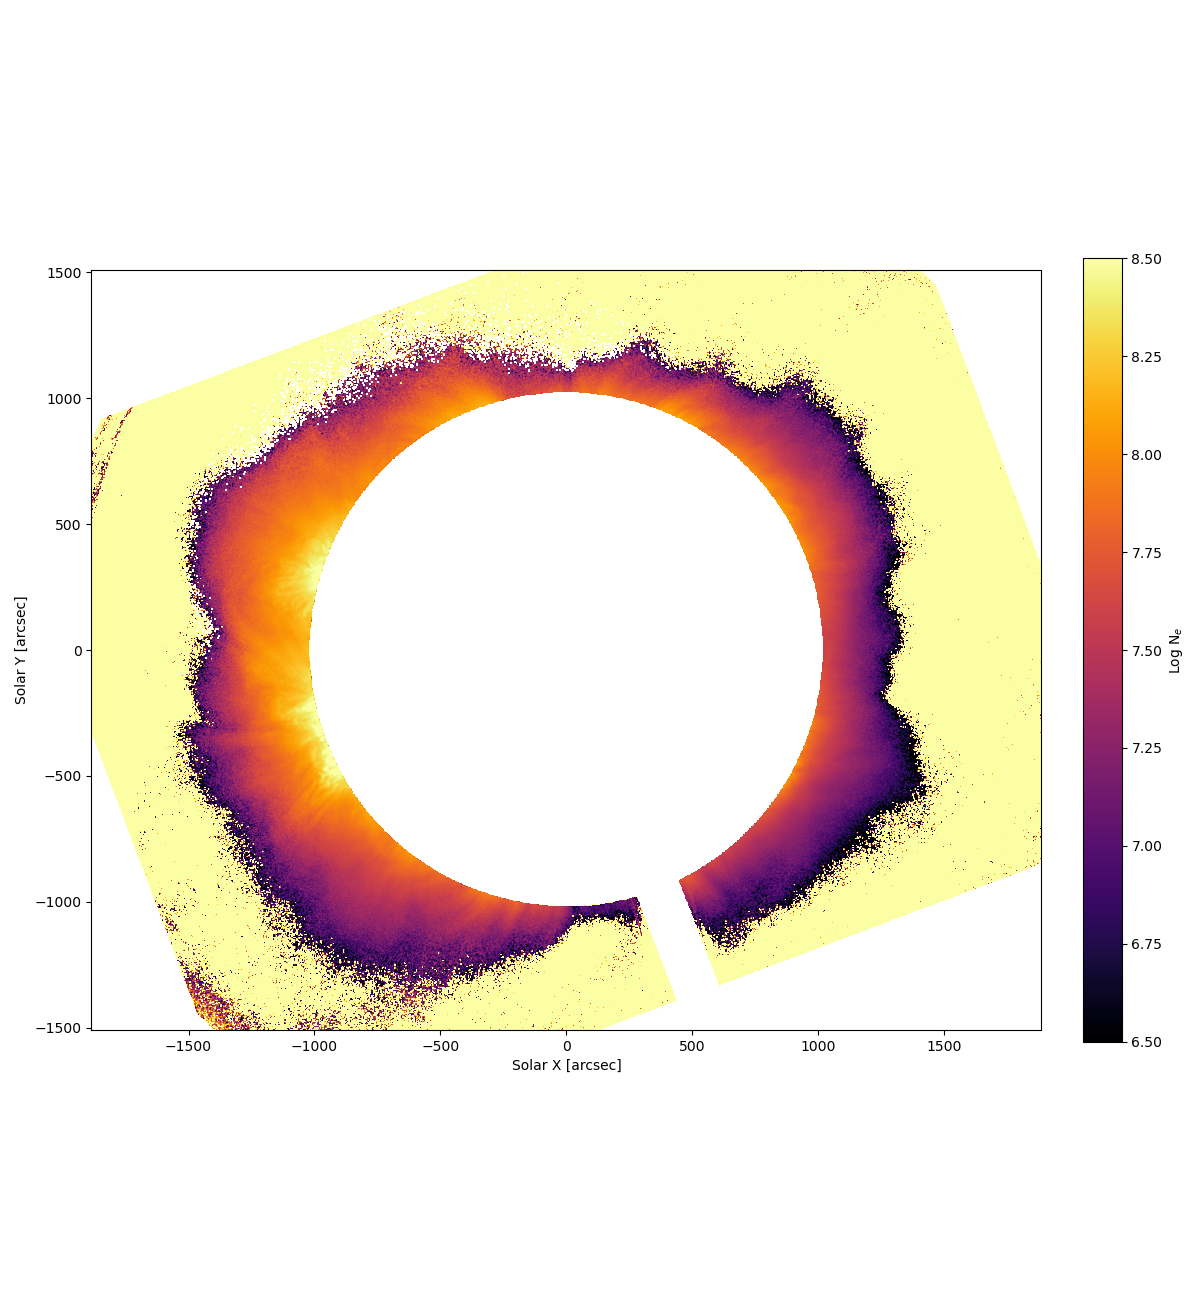

In [163]:
import matplotlib.pyplot as plt
%matplotlib widget

rnge=[-data_1074[0].header["crpix1"]*data_1074[0].header["cdelt1"],data_1074[0].header["crpix1"]*data_1074[0].header["cdelt1"],-data_1074[0].header["crpix2"]*data_1074[0].header["cdelt2"],data_1074[0].header["crpix2"]*data_1074[0].header["cdelt2"]]

plt.figure(figsize=(12,13))
plt.imshow(np.log10(dens_rat_peak),vmin=6.5,vmax=8.5,extent=rnge,cmap='inferno',origin='lower')
plt.colorbar(label='Log N$_e$',fraction=0.038, pad=0.04)
plt.ylabel("Solar Y [arcsec]")
plt.xlabel("Solar X [arcsec]")
plt.tight_layout()

/tmp/ipykernel_3987/1675261318.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(dens_rat_int),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower')
/tmp/ipykernel_3987/1675261318.py:7: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(dens_rat_int),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower')


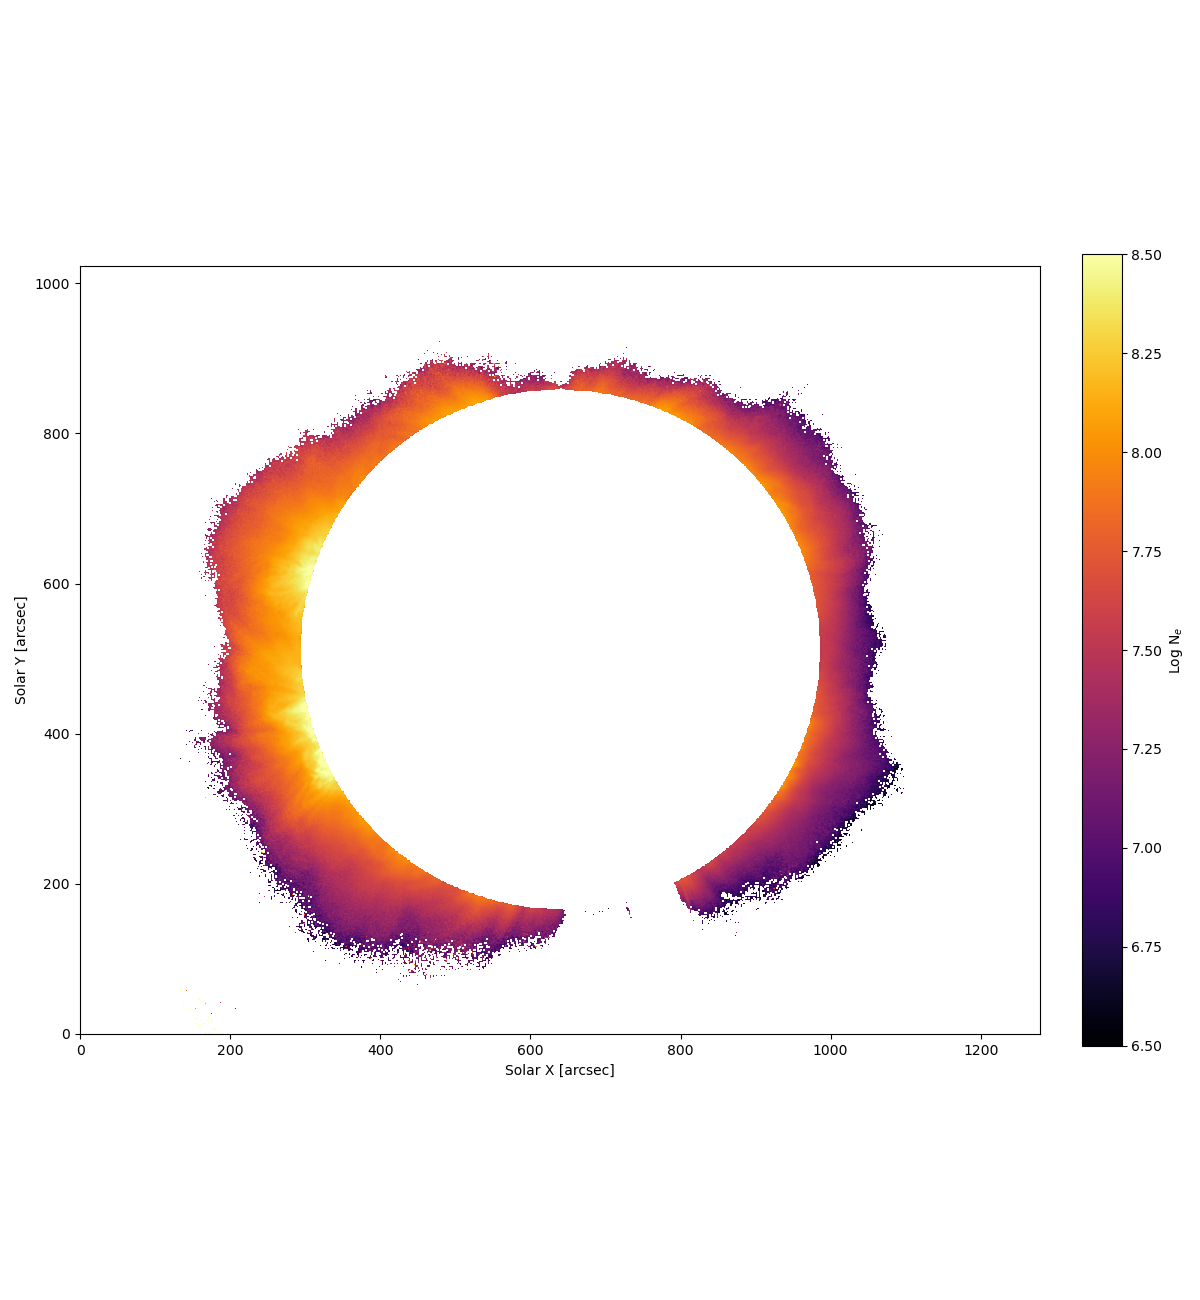

In [164]:
import matplotlib.pyplot as plt
%matplotlib widget

rnge=[-data_1074[0].header["crpix1"]*data_1074[0].header["cdelt1"],data_1074[0].header["crpix1"]*data_1074[0].header["cdelt1"],-data_1074[0].header["crpix2"]*data_1074[0].header["cdelt2"],data_1074[0].header["crpix2"]*data_1074[0].header["cdelt2"]]

plt.figure(figsize=(12,13))
plt.imshow(np.log10(dens_rat_int),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower')
plt.colorbar(label='Log N$_e$',fraction=0.038, pad=0.04)
plt.ylabel("Solar Y [arcsec]")
plt.xlabel("Solar X [arcsec]")
plt.tight_layout()

/tmp/ipykernel_3987/1140622328.py:7: RuntimeWarning: divide by zero encountered in log10
  imc=ax[0].imshow(np.log10(dens_rat_peak),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_3987/1140622328.py:7: RuntimeWarning: invalid value encountered in log10
  imc=ax[0].imshow(np.log10(dens_rat_peak),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_3987/1140622328.py:11: RuntimeWarning: divide by zero encountered in log10
  imc=ax[1].imshow(np.log10(dens_rat_int),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_3987/1140622328.py:11: RuntimeWarning: invalid value encountered in log10
  imc=ax[1].imshow(np.log10(dens_rat_int),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_3987/1140622328.py:15: RuntimeWarning: divide by zero encountered in log10
  imc=ax[2].imshow((np.log10(dens_rat_peak)-np.l

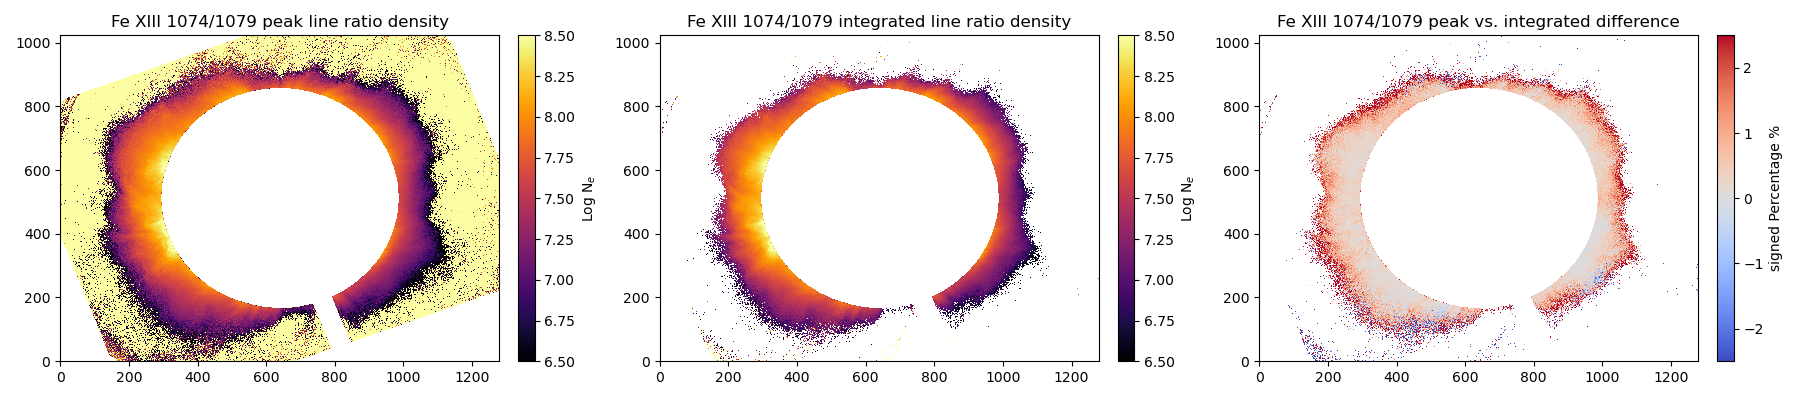

In [169]:
import matplotlib.pyplot as plt
%matplotlib widget

fig,ax = plt.subplots(1,3,figsize = (18,4),width_ratios=[0.33,0.33,0.33])
ax = ax.flatten()

imc=ax[0].imshow(np.log10(dens_rat_peak),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
ax[0].set_title("Fe XIII 1074/1079 peak line ratio density")
fig.colorbar(imc,label="Log N$_e$",fraction=0.038, pad=0.04)

imc=ax[1].imshow(np.log10(dens_rat_int),vmin=6.5,vmax=8.5,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
ax[1].set_title("Fe XIII 1074/1079 integrated line ratio density")
fig.colorbar(imc,label="Log N$_e$",fraction=0.038, pad=0.04)

imc=ax[2].imshow((np.log10(dens_rat_peak)-np.log10(dens_rat_int))/8.5*100,vmin=-2.50,vmax=2.50,cmap='coolwarm',origin='lower',aspect="auto",interpolation="none")
ax[2].set_title("Fe XIII 1074/1079 peak vs. integrated difference")
fig.colorbar(imc,label="signed Percentage %",fraction=0.038, pad=0.04)


plt.tight_layout()

### Extra: Basic example of timeseries matching  

In [55]:
## uCoMP data load - 20220225  ## CoMP data can also be loaded by adapting this script
## L2 data can be donwloaded from https://mlso.hao.ucar.edu/mlso_data_summary.php?date=2022-02-25&inst=ucomp
import os
import glob
from astropy.io import fits
dd1 = './uCoMP-20220225/'
dd1 = './CoMP-20140416/'
os.makedirs(dd1,exist_ok=True)
files1 = glob.glob(dd1 + '*1074.*.fts')
files1.sort()
files2 = glob.glob(dd1 + '*1079.*.fts')
files2.sort()

#files and data load. Data is in the .data dimension of the head_xxxx arrays
head_1074 = []
head_1079 = []
for i in range(len(files1)):
    head_1074.append(fits.open(files1[i]))
for i in range(len(files2)):
    head_1079.append(fits.open(files2[i]))

# ## There are two indices, [a][b] a is the observations in the fits file and "b" is the extension from the ucomp L1/L2 specs; Normally extension 0 has all required information. 
# print(head_1074[0][0].header['instrume']=="UCoMP")
# print(head_1074[0][1].data.shape)
# print(head_1074[0][0].header["R_SUN"],head_1074[0][0].header["RSUN_OBS"])
# print(head_1074[0][0].header["CRPIX1"],head_1074[0][0].header['CRPIX2'])
# print(head_1074[0][0].header["CRVAL1"],head_1074[0][0].header['CRVAL2'])
# print(head_1074[0][0].header["CDELT1"],head_1074[0][0].header['CDELT2'])

In [59]:
from datetime import datetime,timedelta
from scipy.io import readsav

## Concept is: Taking the shortest series(number of frames), and match each frame with the closest matching time in the longer timeseries. 
## NOTE: This does not correct for selecting the same frame in the longer series multiple times, if that is the best match.

## selects the shorted series
aa=[]
bb=[]

if head_1074[i][0].header['instrume'] =="UCoMP": 
    if (len(head_1074) <= len(head_1079)):
        for i in range(len(head_1074)):
            aa.append( head_1074[i][0].header["date-obs"][:19])
        for i in range(len(head_1079)):
            bb.append( head_1079[i][0].header["date-obs"][:19])
    else:
        for i in range(len(head_1079)):
            aa.append( head_1079[i][0].header["date-obs"][:19])
        for i in range(len(head_1074)):
            bb.append( head_1074[i][0].header["date-obs"][:19])
elif head_1074[i][0].header['instrume'] =="COMP":          ## This includes leap sedonds that are not compatible with datetime module. Solve "60"s by changing to "59"s    
    if (len(head_1074) <= len(head_1079)):  
        for i in range(len(head_1074)):
            aa.append( head_1074[i][0].header["date-obs"] + 'T'+head_1074[i][0].header['time-obs'] )
            if aa[-1][-2:] == "60": aa[-1] = head_1074[i][0].header["date-obs"] + 'T'+head_1074[i][0].header['time-obs'][:-2]+"59"  
        for i in range(len(head_1079)):
            bb.append( head_1079[i][0].header["date-obs"] + 'T'+head_1079[i][0].header['time-obs'] )
            if bb[-1][-2:] == "60": bb[-1] = head_1079[i][0].header["date-obs"] + 'T'+head_1079[i][0].header['time-obs'][:-2]+"59"   
    else:
        for i in range(len(head_1079)):
            aa.append( head_1079[i][0].header["date-obs"] + 'T'+head_1079[i][0].header['time-obs'] )
            if aa[-1][-2:] == "60": aa[-1] = head_1079[i][0].header["date-obs"] + 'T'+head_1079[i][0].header['time-obs'][:-2]+"59"  
        for i in range(len(head_1074)):
            bb.append( head_1074[i][0].header["date-obs"] + 'T'+head_1074[i][0].header['time-obs'] )  
            if bb[-1][-2:] == "60": bb[-1] = head_1074[i][0].header["date-obs"] + 'T'+head_1074[i][0].header['time-obs'][:-2]+"59"   
else: print("Instrument not understood. Aborted!")


FMT =  '%Y-%m-%dT%H:%M:%S'                    ## format for the dates that are read
timematch=np.empty([len(aa)],dtype=np.int32)  ## array to store the matched indexes

## Compute the seconds difference between each frame from the shorter dataseries and the entire longer dataseries, 
## and then record the argument of the best difference obtained
for i in np.arange(0,len(aa)):
    bb1=[(np.abs(datetime.strptime(aa[i], FMT)-datetime.strptime(date, FMT))).total_seconds() for date in bb] 
    ## np.abs is needed to preserve the shortest difference when negative differences occur. 
    timematch[i]=np.argmin(bb1)            

## debug print commands that show the best matching frames and time difference    
print("Number of matched frames: ",len(timematch))
#print(timematch)

#for i in np.arange(0,len(aa)):
#    print(aa[i],bb[timematch[i]])

Number of matched frames:  333


### Now, we use COMP_DENS to compute the density for timeseries pair no. XX of Fe XIII 1074 and 1079 observations.

This assumes that the shortes dataset is 1079; indices need to be swaped below if this is reversed in your case.

This can of course be included in a for loop to cycle through all timeseries matching sets of frames.


In [57]:
frameno=16  ## this variable applies to the shorter temporal series; timematch[frameno] retrieves the corresponding entry in the longer timeseries.

dens_rat = COMP_DENS(head_1074[timematch[frameno]][1].data,head_1079[frameno][1].data,'./chianti_v10.1_pycelp_fe13_h99_d120_ratio.npz',head_1074[timematch[frameno]][0].header,head_1079[frameno][0].header) ## line_center [1] extension calculation

#dens_rat=COMP_DENS(c1074_iqu['cube_ii'][timematch[frameno],:,:],c1079_iqu['cube_ii'][frameno,:,:],'./chianti_v10_fe13_h50_ratio.sav',c1074_iqu['index1'])
## in this case the varaibles were "aa" == c1079_iqu and "bb" == c1074_iqu 

Time between selected frames: 48.0 [s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 384400/384400 [00:00<00:00, 2769582.78it/s]


Simple plot of the results

/tmp/ipykernel_33842/2890756712.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(dens_rat),vmin=7,vmax=8.5,extent=rnge,cmap='inferno',origin='lower')


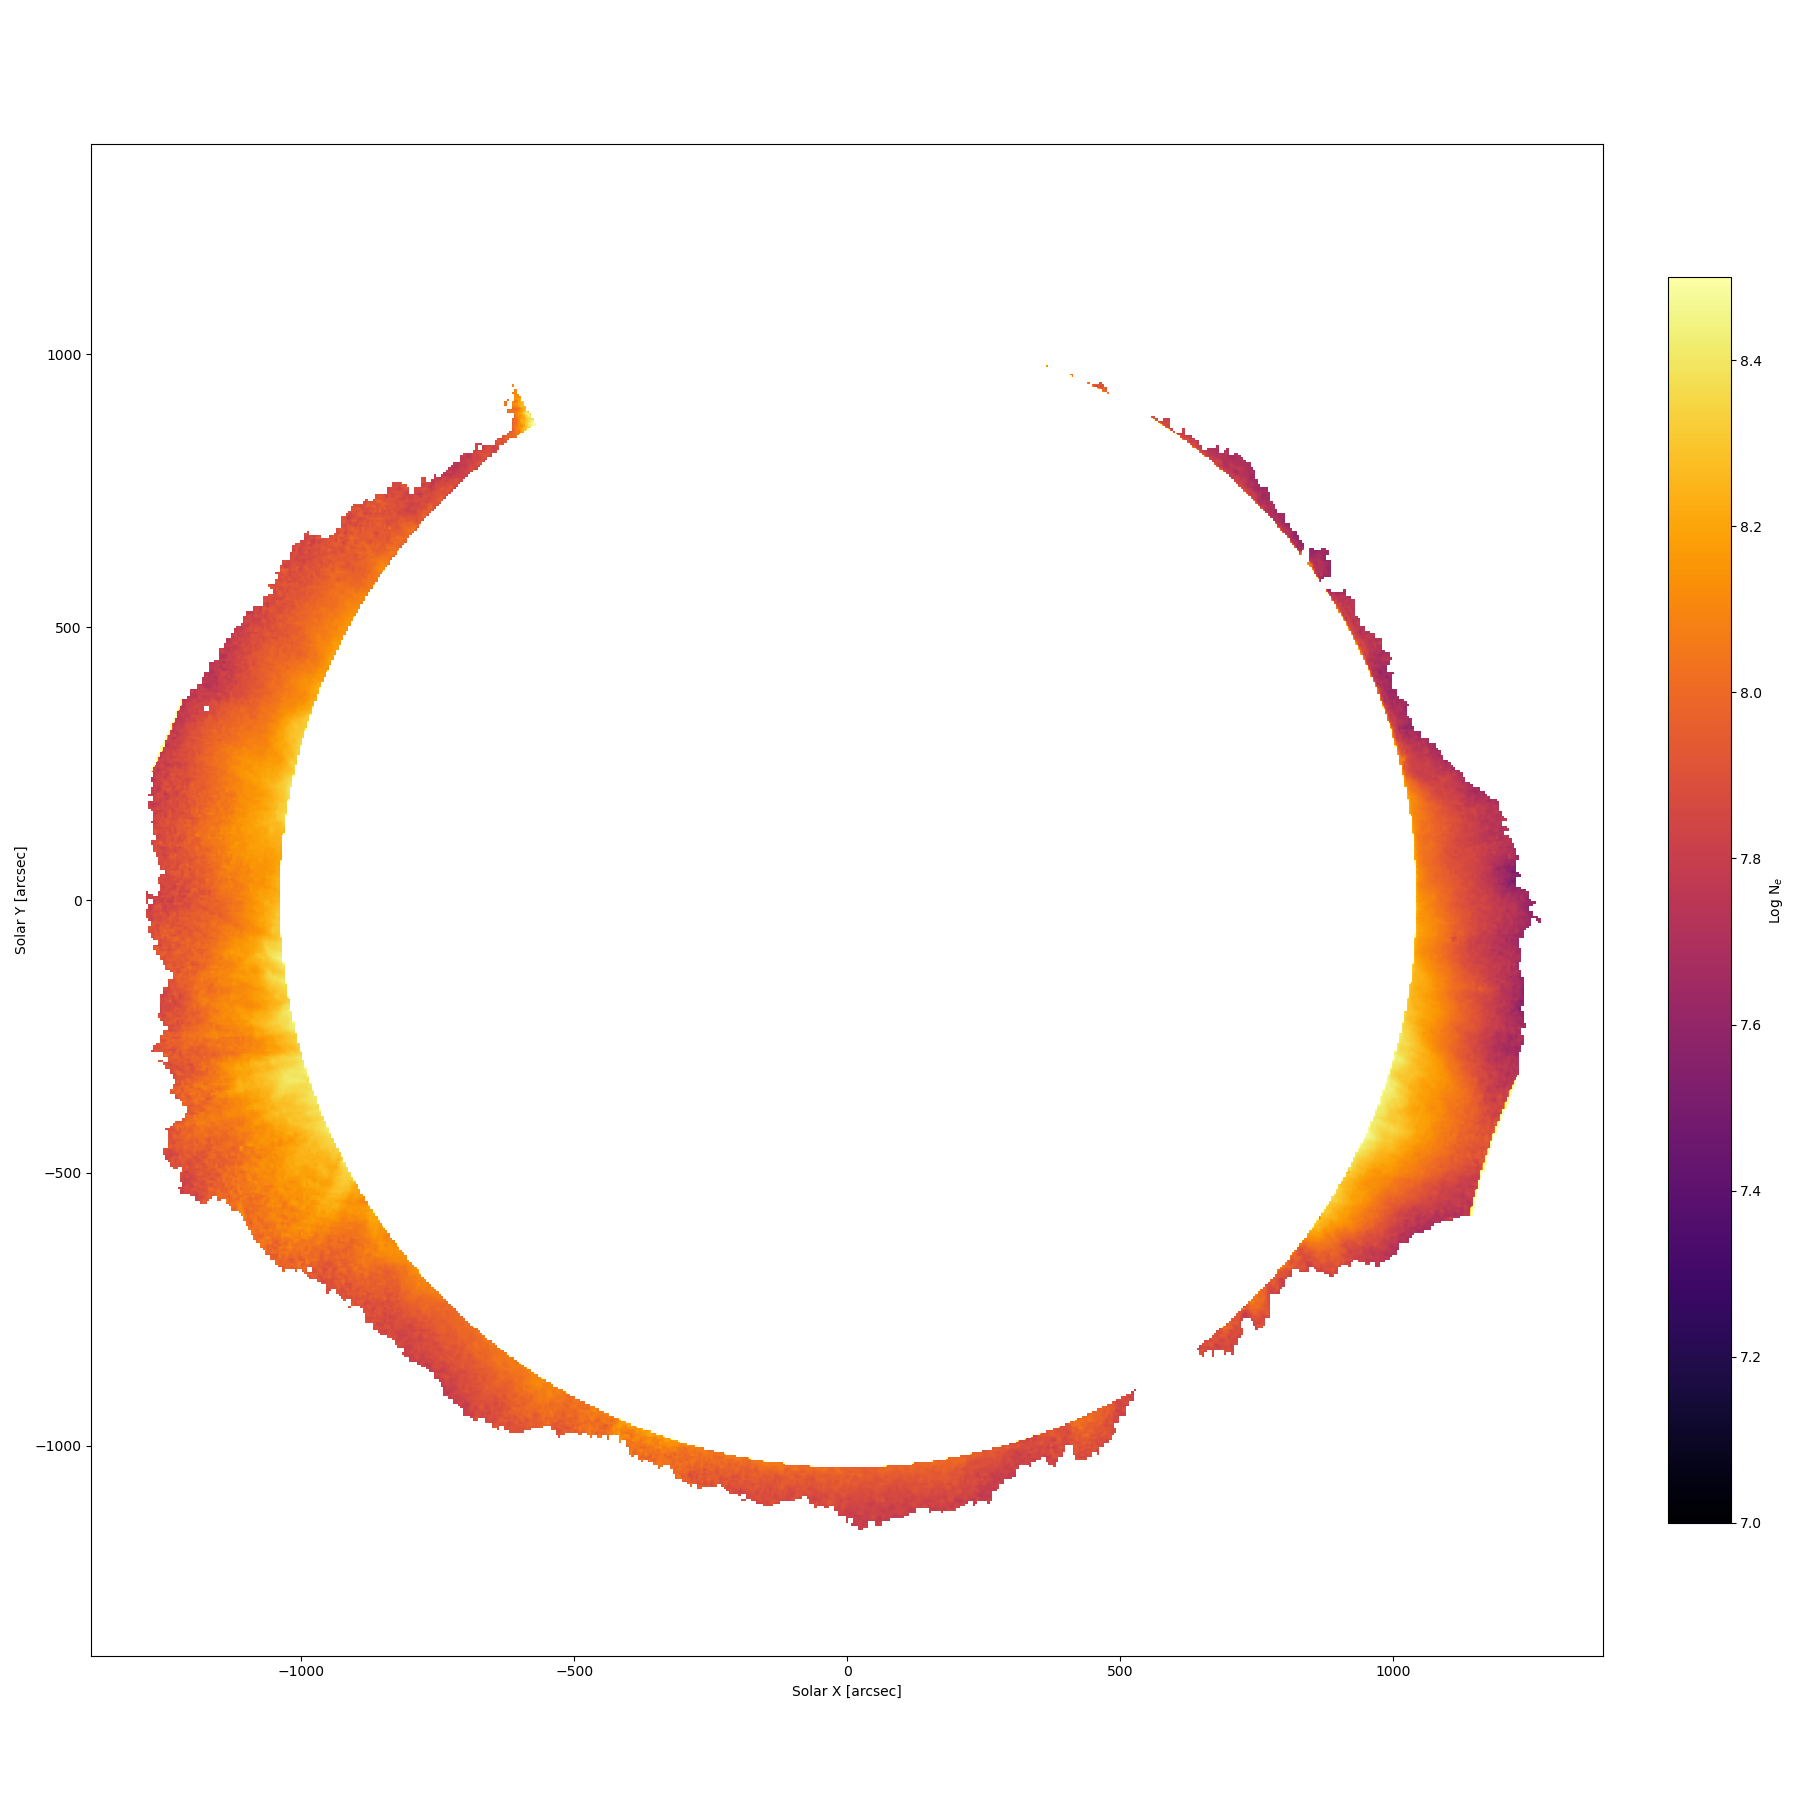

In [58]:
import matplotlib.pyplot as plt
%matplotlib widget

rnge=[-data_1074[0].header["crpix1"]*data_1074[0].header["cdelt1"],data_1074[0].header["crpix1"]*data_1074[0].header["cdelt1"],-data_1074[0].header["crpix2"]*data_1074[0].header["cdelt2"],data_1074[0].header["crpix2"]*data_1074[0].header["cdelt2"]]

plt.figure(figsize=(18,18))
plt.imshow(np.log10(dens_rat),vmin=7,vmax=8.5,extent=rnge,cmap='inferno',origin='lower')
plt.colorbar(label='Log N$_e$',fraction=0.038, pad=0.04)
plt.ylabel("Solar Y [arcsec]")
plt.xlabel("Solar X [arcsec]")
plt.tight_layout()